In [1]:
import warnings
warnings.filterwarnings('ignore')

# Introduction to Quantum Compilation with TKET


<div class="alert alert-block alert-info"> 
 <p>In this blog post we will introduce some key ideas for compiling quantum circuits. We will also demonstrate some key features of TKET through its python interface.</p>
  <ol>
    <li>Constructing circuits </li>
    <li>Converting between different circuit formats</li> 
    <li>Compiling circuits for different quantum devices and classical simulators</li> 
    <li>Optimising quantum circuits to improve their perfromance </li>
  </ol>
    We will assume some familiarity with quantum circuits as well as some basic knowledge of python programming and linear algebra. This notebook can be viewed on <nav><a href=”/css/”>Github</a> </nav></div>

Present day quantum computers suffer from prohibitive noise and have complex constraints on the kinds of programs they can run. In general a non-trival compilation step is required to translate a program to a form that can be executed on a real quantum device.

TKET is a quantum software toolkit and compiler designed to simplify quantum experiments. A traditional compiler can translate a human readable program to a form that can be executed as low level machine code. Analogously TKET can compile a high level description of a quantum algorithm to a form that can be implemented on a real quantum computer.

Importantly TKET has numerous optimisation tools to reduce the resources needed for near term quantum experiments. Such circuit optimisations can significantly improve the performance of algorithms by effectively mitigating against noise. In addition TKET has extension modules which enable the user to access hardware and simulators from different providers. These extensions also enable functionality with other popular quantum software packages including qiskit, cirq and more.

## Circuit Basics in pytket

Circuits can be defined and visualised easily using the pytket python interface. Let's define a simple circuit that prepares and measures the familiar Bell state. The state can be written using Dirac notation as follows.

$$ \left| \psi \right\rangle = \frac{1}{\sqrt{2}} \big( \left| 00 \right\rangle + \left| 11 \right\rangle\big) $$

In [18]:
from pytket import Circuit # import Circuit class
from pytket.circuit.display import render_circuit_jupyter # import circuit renderer

bell_circ = Circuit(2) # Create an instance of the Circuit class with two qubits
bell_circ.H(0) # add a Hadamard gate to the 0th qubit
bell_circ.CX(0,1) # add a CX (or CNOT gate) with control qubit 0 and target qubit 1
bell_circ.measure_all() # measure all of the qubits in the circuit (This adds two classical registers)

render_circuit_jupyter(bell_circ) # visualise the circuit using the circuit renderer

The rendered circuit diagram has user interface icons to the left of the display. These icons cane be used to toggle between different representations of the circuit. Readers familiar with the ZX calculus can view the circuit as a ZX diagram instead of a traditonal quantum circuit.

A useful feature of TKET is the ability to work with other popular quantum software tools including qiskit, cirq, AWS Braket and more. Programmers may wish to convert between different types of circuit to use different features of these libraries. Lets define the same Bell circuit as above using Qiskit convert it to a TKET circuit. 

In [1]:
from qiskit import QuantumCircuit

qiskit_circ = QuantumCircuit(2)
qiskit_circ.h(0)
qiskit_circ.cx(0,1)
qiskit_circ.measure_all()

qiskit_circ.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

This circuit can now be converted to a TKET circuit using the ``qiskit_to_tk`` function from the pytket-qiskit extension. Note that in qiskit the ``measure_all`` method adds a barrier prior to measurement.

In [21]:
from pytket.extensions.qiskit import qiskit_to_tk

tk_circ = qiskit_to_tk(qiskit_circ) # convert a qiskit circuit to a TKET circuit using
#the qiskit_to_tk function

render_circuit_jupyter(tk_circ) # visualise the TKET circuit

Note that there is another function ``tk_to_qiskit`` which converts a circuit from a TKET to a qiskit format. There are also similar conversion functions from other extension modules.

TKET has many extension modules for interfacing with different types of quantum hardware and classical simulators. Let's simulate our Bell circuit using the ``AerBackend`` Simulator from the pytket-qiskit extension. This simulator is noiseless by default.

In [17]:
from pytket.extensions.qiskit import AerBackend # import AerBackend from the pytket-qiskit extension

noiseless_backend = AerBackend() # initialise our backend
handle = noiseless_backend.process_circuit(bell_circ, n_shots=1000) # process our circuit (1000 shots)
result = noiseless_backend.get_result(handle) # retrieve our result using the handle

result_counts = result.get_counts() # use get_counts() method to retrieve {shots:counts} dictionary
print(result_counts)

Counter({(1, 1): 503, (0, 0): 497})


As you can see we obtain approximately equal number of counts in the (0,0) and (1,1) basis states. This is what one would expect from measuring the Bell state. Even although the simulator is noiseless we would not expect an exact 50:50 distribution as there as we are still randomly sampling. If you flip a fair coin 1000 times its unlikely to give heads and tails 500 times each!

So far so good. However the experiment we have just performed is simplistic in many ways. Not only have we simulated a trivial circuit but the ``AerBackend`` has no hardware noise and a diverse set of quantum gates available. Furthermore there are no complications introduced by the qubit layout as the ``AerBackend`` has "all-to-all" connectivity. In a more realistic quantum experiment all of these considerations will need to be taken into account.

Lets consider a slightly more complex example using a phase estimation circuit. Quantum phase estimation (QPE) is an important subroutine that occurs in many quantum algorithms including Shor's algorithm and Hamiltonian simulation.

Phase estimation allows us to estimate the eigenvalue of a unitary operator $U$ applied to some input state. 

$$ U \left| \psi \right\rangle = e^{2 \pi i \theta} \left|\psi \right \rangle $$

The eigenvalue can be expressed as $e^{2 \pi i \theta}$ as the eigenvalue of a unitary operator has norm 1. Quantum phase estimation allows us to estimate the phase $\theta$ which will be encoded in the measurement results.

We can implement an algorithm to estimate $\theta$ using some controlled unitary operations along with some swap operations and single qubit gates. We could define this circuit by sequentially adding gates but lets define our circuit using a qasm file (*). For ease of visualisation we will start with a three qubit circuit.


In [7]:
from pytket.qasm import circuit_from_qasm

qpe2_circ = circuit_from_qasm('qpe2.qasm') # qpe circuit with two measurement qubits and one phase qubit.
render_circuit_jupyter(qpe2_circ)

<div class="alert alert-block alert-warning">
<b>Exercise:</b> We have defined this QPE circuit using a qasm file. Can you construct the circuit using pytket? Read more about the structure of phase estimation circuits and see if you can define a function that returns a quantum phase estimation circuit that measure the phase on a single qunit using $n$ measurement qubits.
</div>

Our circuit contains single qubit gates (Hadamard and X gates) as well as multi-qubit SWAP and CU1 gates. To read more about how these gates are defined click `here`. We can also count the number of gates in our circuit as follows using the OpType enum.

In [8]:
from pytket import OpType

print('Gate count = ' , qpe2_circ.n_gates)
print('Two qubit gate count = ', qpe2_circ.n_gates_of_type(OpType.CU1) +
 qpe2_circ.n_gates_of_type(OpType.SWAP))

Gate count =  12
Two qubit gate count =  5


Gate count is a natural metric to keep track of when compiling quantum circuits. The two qubit gate count is particularly important to bear in mind as these gates can be roughly an order of magnitude noisier and slower to implement on hardware than single qubit gates. In fact much of circuit optimisation focuses on reducing the two qubit gate count as we shall see shortly.

## Understanding Device constraints

From now on we will consider a phase estimation circuit with an extra qubit (and lots of extra gates!). This will hopefully make certain points around circuit compilation clearer.

In [9]:
qpe3_circ = circuit_from_qasm('qpe3.qasm') # qpe circuit with three measurement qubits and one phase qubit.
render_circuit_jupyter(qpe3_circ)

print('Gate count = ' , qpe3_circ.n_gates)
print('Two qubit gate count = ', qpe3_circ.n_gates_of_type(OpType.CU1) +
 qpe3_circ.n_gates_of_type(OpType.SWAP))

Gate count =  21
Two qubit gate count =  11


Lets now think about how to run our phase estimation circuit on an actual quantum computer (or at the very least a more realistic simulator! ) Lets use the ``IBMQEmulatorBackend`` from the ``pytket-qiskit`` extension. This is a simulator that attempts to capture the noise of real IBM superconducting device (The IBMQ Belem device is used here). To make our experiment more realitic our circuit must satisfy all the constraints of the real device in order to run on the simulator.

In [10]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

IBMQ_belem_backend = IBMQEmulatorBackend('ibmq_belem', hub='partner-cqc', group='internal', project='default') # initialise IBMQEmulatorBackend for the Belem device

Quantum devices and emulators will support a small but universial set of quantum gates. Before we can run a circuit on this IBM emulator our circuit must be in the correct gateset. To see which gates are supported we can use the ``backend_info.gate_set`` attribute of our backend.

In [11]:
IBM_gateset = IBMQ_belem_backend.backend_info.gate_set
print(IBM_gateset)

{<OpType.Rz: 33>, <OpType.U3: 34>, <OpType.U2: 35>, <OpType.U1: 36>, <OpType.CX: 39>, <OpType.Reset: 60>, <OpType.X: 20>, <OpType.noop: 57>, <OpType.Measure: 58>, <OpType.SX: 28>}


Notice how the CU1, H and SWAP operations are not in our ``IBM_gateset`` (the X gate is). This means we will have to find some way to translate our circuit to the gates that are supported by our backend. Note that the numbers next to each OpType are simply indices in the enum and are not properties of the device itself.

An additional constraint that is sometimes forgotten is the circuit connectivity. Textbook presentations of quantum algorithms often assume that all of the qubits a circuit can interact with one another freely. However when it comes to real quantum devices this may not be the case. For instance the IBM Belem device only allows interaction between qubits which are next to each other. This means that additional gates must be inserted into our circuit in order to realise all of the interactions in our phase estimation circuit.

We can visualise the connectivity of our phase estimation circuit by looking at the interaction graph. In an interaction graph the qubits in our circuit are represented by the vertices of the graph. Two vertices are connected by an edge if there is a multi-qubit gate acting between the two qubits represented by the vertices.

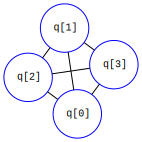

In [15]:
from pytket.utils import Graph

Graph(qpe3_circ).get_qubit_graph() # Visualise the connectivity of our "program qubits"

Notice how we have all possible interactions between our qubits. Put differently, our interaction graph is 
the complete graph $K_4$. Lets now take a look at how our qubits are laid out on the device itself. Bear in mind that only nearest-neighbor interaction is permitted between the qubits.

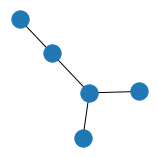

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(IBMQ_belem_backend.backend_info.architecture.coupling) # interaction graph as a networkx graph
plt.figure(figsize=(2,2))
nx.draw(G)
plt.show() # Visualise how the qubits are laid out on the device

Notice how the connectivity of the device is places restrictions on the gates that can be performed. We will need to add additional SWAP gates to our circuits to realise the interactions in our phase estimation circuit. The problem of satisfying circuit connectivity without adding too many extra gates is called the **qubit routing problem** [ref]. We will not consider routing in detail in what follows (Perhaps in a forthcoming blog post!).

## Circuit Compilation with the Quantinuum Backend.

Now that we understand more about the restrictions imposed by quantum hardware lets find out how TKET can solve for our device constraints and even optimise our circuit for better performance.

TKET is designed to make working with different hardware platforms as seamless as possible. In fact there are numerous extension modules that allow the user to interface with a range of quantum hardware. This enables the user to try out the pros and cons of different hardware platforms as they come online without having to rewrite their code.

To demonstrate this lets compile our phase estimation circuit for a Quantinuum ion trap device. Lets initialise our new backend and see which gates it supports.

In [14]:
from pytket.extensions.quantinuum import QuantinuumBackend 

H1E_backend = QuantinuumBackend('H1-1E') # emulator for the H1 ion trap device
gate_set = H1E_backend.backend_info.gate_set
print(gate_set)

Enter your Quantinuum email:  callum.macpherson@cambridgequantum.com
Enter your Quantinuum password:  ···············


{<OpType.ZZMax: 65>, <OpType.Rz: 33>, <OpType.ZZPhase: 68>, <OpType.Barrier: 6>, <OpType.WASM: 12>, <OpType.SetBits: 13>, <OpType.CopyBits: 14>, <OpType.RangePredicate: 15>, <OpType.ExplicitPredicate: 16>, <OpType.ExplicitModifier: 17>, <OpType.MultiBit: 18>, <OpType.ClassicalExpBox: 87>, <OpType.Measure: 58>, <OpType.Reset: 60>, <OpType.PhasedX: 63>}


We see that the Quantiunuum native gate set is {ZZMax, Rz, PhasedX, ZZPhase}. TKET can translate automatically to the target gate set by using the ``get_complied_circuit`` method for our ``QuantinuumBackend``. Lets do this translation and see how it effects the number of gates in our circuit.

In [ ]:
compiled_circuit = H1E_backend.get_compiled_circuit(qpe3_circ)
render_circuit_jupyter(compiled_circuit)

print('Gate count = ', compiled_circuit.n_gates)
print('Two qubit gate count = ', compiled_circuit.n_gates_of_type(OpType.ZZMax))

Notice how the circuit has now been transformed to the Quantinuum native gateset. This compilation has also significantly increased our gatecount. Compare with our original QPE circuit with 21 gates and 11 two qubit gates! 

On noisy hardware more gates means more errors will accumulate over the course of our computation introduce additional noise in our results. This motivates the idea of circuit optimisation. The question aries - how can we compile our circuit to our target device without adding too many extra noisy gates?

Pytket can optimise circuits in numerous ways. Each pytket ``Backend`` object has a method called ``default_compilation_pass``. This method applies a predefined sequence of optimistaions to our circuit that is tailor made for each device. 

This method also takes an ``optimistaion_level`` parameter. Setting ``opimisation_level=1`` will solve for the device constraints and apply some light optimsisation. The highest level of optimisation (``optimisation_level=2``) applies intensive optimisations but may take longer to run for large circuits. 

Lets now apply this default compilation pass to our circuit with the highest level of optimisation available and see how this effects our gate count.

In [ ]:
qpe3_circ = circuit_from_qasm('qpe3.qasm')

H1E_backend.default_compilation_pass(optimisation_level=2).apply(qpe3_circ)

render_circuit_jupyter(qpe3_circ)

print('Gate count = ', qpe3_circ.n_gates)
print('Two qubit gate count = ', qpe3_circ.n_gates_of_type(OpType.ZZMax))

We now see a substantial reduction in the gate count compared with the naively compiled circuit. The two qubit gate count is more than halved which will reduce the noise in our results when we run our circuit.

We have managed to find an implementation of our phase estimation circuit that meets our hardware constraints and does not have any additional two qubit gates introduced in the compilation process.

In this tutorial we have made use of the predefined circuit transformations applied by the ``get_compiled_circuit`` and ``default_compilation_pass`` methods. TKET also supports user defined sequences of optimisations which will be covered in another tutorial.

## Applying Circuit Optimisation in an Experiment

Lets finish off by comparing the results of a phase estimation experiment before and after circuit optimisation is applied. In the plot below a bigger circuit phase estimation circuit was run on the ``IBMQEmulatorBackend``.

This was a [5+1] qubit phase estimation experiment performed on an emulator for the IBMQ Guadalupe device with 1000 shots. In this experiment the expected output is the (0,1,1,0,1) basis state. This is our measurement result from which we can extract the phase $\theta$ .


We perform the experiment first with a circuit obtained using the ``get_compiled_circuit`` method for the IBM backend.

Next we apply a sequence of optimisations to our circuit to optimise it for our chosen backend

<div class="alert alert-block alert-info">
<b>Circuit info:</b>
  <ol>
    <li>Circuit 1: (Before optimisation) - 226 total quantum gates,  118 CX gates, CX Depth = 105 </li>
    <li>Circuit 2: (After optimisation) -   154 total quantum gates,  60 CX gates, CX Depth = 48 </li>
 </ol>
    
The second circuit has approximately half the CX Depth and gate count when compared with the first. Given this we would expect the second set of results to be less corrupted by noise with more of our measurements returning the "correct" result. 
</div>

<center><img src="qpe_results_comparison.png" style=width:1622px;height:400px /></center>

We observe that the number proportion of measurements that give the "correct" result has notably increased (from 255/1000 to 532/1000). Equivalently we could say that the success probability of our algorithm has increased from 25.5% to 53.2%. The "incorrect" measurement results shown by the orange bars are also suppressed by the optimisation.

The improved results reflect the reduced noise in the computation. This tells us that our sequence of optimisations has been an effective way to mitigate noise in our circuit. 

## Conclusion

In this blog post we have discussed some challenges with near term quantum computing and introduced TKET as a quantum compiler. We have also learned how to construct and optimise quantum circuits for different backends. 

## Useful Links 

- pytket user manual --> https://cqcl.github.io/pytket/manual/index.html
- pytket notebook examples --> https://github.com/CQCL/pytket/tree/main/examples

## Further reading

- TKET white paper --> https://arxiv.org/abs/2003.10611
- More theory background on quantum phase estimation --> Nielsen & Chuang Chapter 5, (p221-226)